In [1]:
import torch
import torch.nn as nn
from torch.distributions import Normal, Gamma, MultivariateNormal

from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

from tqdm import tqdm_notebook as tqdm

In [11]:
from tt_model import TTModel
from tt_model import vectorize_params, unvectorize_params
from tt_model import calc_ranks_from_particles, get_lambdas_vec

config = {
    'resize_shape': (32, 32),
    
    'in_factors': (4, 4, 4, 4, 4),
    'l1_ranks': (8, 8, 8, 8),
    'hidd_out_factors': (2, 2, 2, 2, 2),
    'ein_string1': "nabcde,aoiv,bijw,cjkx,dkly,elpz",
    
    'hidd_in_factors': (4, 8),
    'l2_ranks': (16,),
    'out_factors': (5, 2),
    'ein_string2': 'nab,aoix,bipy',
}

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
cfg = AttrDict(config)

model = TTModel(cfg)

In [21]:
NUM_LABELS = 10
MNIST_TRANSFORM = transforms.Compose((
    transforms.Pad(2),
    transforms.ToTensor(),
    transforms.Normalize((0.1,), (0.2752,))
))

device = torch.device('cpu')

train_size = 40000
batch_size = 100
dataset = MNIST('mnist', train=True, download=True, transform=MNIST_TRANSFORM)

In [4]:
train_dataset, val_dataset = random_split(dataset, (train_size, len(dataset) - train_size))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=(device.type == "cuda"))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, pin_memory=(device.type == "cuda"))

model = model.to(device)

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.95, weight_decay=0.0005)

In [5]:
def log_prior(model, lambdas=None, a_l=1, b_l=5):
    log_prior_sum = 0
    for name, core_tensor in model.named_parameters():
        if 'tt' not in name:
            continue
            
        core_mean = torch.zeros_like(core_tensor)
        
        if lambdas is None:
            core_std = torch.ones_like(core_tensor)
        else:
            layer_idx = int(name.split('tt')[-1].split('.')[0])
            core_idx = int(name.split('cores.')[-1])
            
            prev_rank = core_tensor.shape[1]
            next_rank = core_tensor.shape[2]
        
            if prev_rank == 1:
                l_next = lambdas[layer_idx][core_idx]
                l_prev = l_next
            elif next_rank  == 1:
                l_prev = lambdas[layer_idx][core_idx - 1]
                l_next = l_prev
            else:
                l_prev = lambdas[layer_idx][core_idx - 1]
                l_next = lambdas[layer_idx][core_idx]
            
            core_std = torch.einsum('p,q->pq', l_prev, l_next)
            core_std = core_std.repeat(core_tensor.shape[0], core_tensor.shape[3], 1, 1).permute(0, 2, 3, 1)
            
        log_prior_sum += Normal(core_mean, core_std).log_prob(core_tensor).sum()
    
    if lambdas is not None:
        for layer_lambdas in lambdas:
            for l in layer_lambdas:
                log_prior_sum += Gamma(a_l, b_l).log_prob(l).sum()
        
    return log_prior_sum
        


def log_posterior(model, input, gt, lambdas=None, likelihood_coef=1.):
    """Calculate log-posterior for core tensors and lambdas (optional)

    Parameters:   
        model : TT-model with core tensors as parameters, 
        input : Model input
        gt : Ground truth
        lambdas : LR-parameters \lambda, if any
        likelihood_coef : Coefficient to multiply log-likelihood by (for batches)
    
    Returns:
        Log-posterior 
    """
    
    log_g = torch.nn.functional.log_softmax(model(input), dim=1)
    log_likelihood = (gt * log_g).sum()
    
    #print(out, log_g)
    
    log_prior_sum = log_prior(model, lambdas, 1, 5)
    
    # not including margnial log-likelihood log(p(D))
    return likelihood_coef * log_likelihood + log_prior_sum


Sampling...


/home/maria/Skoltech/bmml/project/lrbtnn/tt_model.py:92: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for lambda_ in lambdas


Estimating bandwith...
Fitting MeanShift...


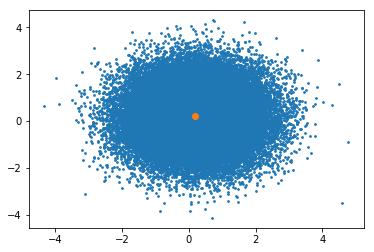

In [23]:
def svgd(particles, dataloader=train_loader, kernel_sigma_squared=1., eps=1e-4, n_steps=100):
    for step in tqdm(range(n_steps)):
        log_posterior_grads = []
        kernels = []
        phi = []

        for theta, (b, gt) in zip(particles, dataloader):
            model, lambdas = unvectorize_params(theta, cfg)

            onehot_gt = torch.zeros(gt.shape[0], NUM_LABELS).scatter_(1, gt.view(-1, 1), 1)
            log_posterior_i = log_posterior(model, b, onehot_gt, lambdas)
            log_posterior_i.backward()
            log_posterior_grad = theta.grad

            log_posterior_grads.append(log_posterior_grad)
            theta.grad.data.zero_()

            kernels.append(MultivariateNormal(theta, kernel_sigma_squared * torch.eye(theta.shape[0])))

        for k, theta_k in enumerate(particles):
            phi_k = 0
            for i, theta_i in enumerate(particles):
                #theta_i.grad.data.zero_()

                kernel_ik = torch.exp(kernels[k].log_prob(theta_i))
                kernel_ik.backward()
                kernel_ik_grad = theta_i.grad
                theta_i.grad.data.zero_()

                phi_k += kernel_ik * log_posterior_grads[i] + kernel_ik_grad
            phi_k /= len(particles)
            phi.append(phi_k)

        for k, phi_k in enumerate(phi):
            particles[k].data.add_(eps * phi_k)

    return particles

def get_svgd_ranks(n_particles=10, n_steps=100, rank_as_mean=False, a_l=1, b_l=5, kernel_sigma_squared=1.):
    # sample particles:
    # * initialize empty model for G's
    # * sample lambdas from priors
    # * vectorize the particle
    particles = []
    for n in range(n_particles):
        model = TTModel(cfg)
        lambdas = []
        layer_ranks = [cfg.l1_ranks, cfg.l2_ranks]
        for layer in range(2):
            lambdas.append([])
            for j, rank in enumerate(layer_ranks[layer]):
                lambdas[layer].append(Gamma(a_l, b_l).rsample([rank]))
        
        particle = vectorize_params(model, lambdas).detach()
        particle.requires_grad_(True)
        particles.append(particle)
            
    # n_steps times perform svgd_step
    svgd_particles = svgd(particles, kernel_sigma_squared=kernel_sigma_squared)

    if rank_as_mean:
        # calculate mean of posterior lambdas
        pass
    else:
        breakpoint()
        # calculate mode of posterior lambdas
        ranks = calc_ranks_from_particles(cfg, svgd_particles, 
                                          kernel_sigma_squared=kernel_sigma_squared, 
                                          how='mode')

    
    return ranks, svgd_particles
    
ranks, svgd_particles = get_svgd_ranks(5)

In [31]:
torch.sum(l < 1e-2)

tensor(3)

In [32]:
ls = []

In [24]:
ranks

[[8, 8, 8, 8], [16]]

In [33]:
for t in svgd_particles:
    m, l = unvectorize_params(t, cfg)
    l = get_lambdas_vec(l)
    ls.append(l)
    
    print(f'Shape of t: {l.shape}')
    print(l.abs().min().item(), l.abs().max().item(), (l.abs() < 1e-2).sum().item())

Shape of t: torch.Size([48])
0.00841329712420702 0.8467715382575989 2
Shape of t: torch.Size([48])
0.007281014230102301 0.8921012878417969 1
Shape of t: torch.Size([48])
0.003815546166151762 1.0169204473495483 1
Shape of t: torch.Size([48])
0.007859569974243641 0.7887188196182251 1
Shape of t: torch.Size([48])
0.002039548009634018 1.1319605112075806 3


In [47]:
foo = torch.cat(ls).reshape(-1, 48).detach().cpu().numpy()

In [48]:
from find_mode import find_max_mode

In [50]:
find_max_mode(foo, 0.3) < 1e-2

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [47]:
lambdas = []
layer_ranks = [cfg.l1_ranks, cfg.l2_ranks]
for layer in range(2):
    lambdas.append([])
    for j, rank in enumerate(layer_ranks[layer]):
        l = Gamma(1, 5).rsample([rank])
        l.requires_grad_(True)
        lambdas[layer].append(l)

model = TTModel(cfg)
theta = vectorize_params(model, lambdas).detach()
theta.requires_grad_(True)

print(theta.requires_grad)

a = theta.sum()
a.backward()
print(theta.grad)

True
tensor([1., 1., 1.,  ..., 1., 1., 1.])


In [48]:
theta.shape

torch.Size([2288])

In [25]:
theta.requires_grad

True

In [27]:
x = torch.ones(3, 4)
y = 2 * x
z = 3 * y
z.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [13]:
def acc(model, loader):
    accs = []
    with torch.no_grad():
        for b, gt in tqdm(loader):
            out = model(b.to(device)).argmax(1).cpu().numpy()
            gt = gt.numpy()
            accs.append(sum(out == gt) / len(out))
    return sum(accs) / len(accs) 

learning_rate = 1e-3
n_epochs = 100

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for ep in range(n_epochs):
    for b, gt in tqdm(train_loader):
        
        optimizer.zero_grad()
    
        onehot_gt = torch.zeros(gt.shape[0], NUM_LABELS).scatter_(1, gt.view(-1, 1), 1)

        likelihood_coef = len(train_dataset) / batch_size
        loss = -log_posterior(model, b.to(device), onehot_gt.to(device), likelihood_coef=likelihood_coef)
        
        loss.backward()
        optimizer.step()
    
    print(loss.item())
    #print(acc(model, val_loader))
    

None

